### Load in Image Data

In [1]:
import pickle

classnames = ['sax, saxophone', 'limousine, limo', 'church, church building', 'yurt', 'obelisk']

img_loader = pickle.load(open('pickle_jar/5_1-train_100-mean_normalized.p', 'rb'))

img_info = img_loader.image_info

### Build VGGNet

In [2]:
from train import Model

m = Model()

m.build_model(img_info.num_channels, img_info.img_width, img_info.img_height, img_info.num_classes, 'vgg16')

Using Theano backend.
/home/ebanner/.anaconda/envs/py27/lib/python2.7/site-packages/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")


Building "vgg16" model.
--------------------------------------------------------------------------------
Initial input shape: (None, 3, 256, 256)
--------------------------------------------------------------------------------
Layer (name)                  Output Shape                  Param #             
--------------------------------------------------------------------------------
ZeroPadding2D (zeropadding2d) (None, 3, 258, 258)           0                   
Convolution2D (convolution2d) (None, 64, 256, 256)          1792                
ZeroPadding2D (zeropadding2d) (None, 64, 258, 258)          0                   
Convolution2D (convolution2d) (None, 64, 256, 256)          36928               
MaxPooling2D (maxpooling2d)   (None, 64, 128, 128)          0                   
ZeroPadding2D (zeropadding2d) (None, 64, 130, 130)          0                   
Convolution2D (convolution2d) (None, 128, 128, 128)         73856               
ZeroPadding2D (zeropadding2d) (None, 128, 13

### Load Weights

In [3]:
m.model.load_weights('weights/word2vec_aff/16-val.h5')

### Predict Test Images

In [4]:
%%time

probs = m.model.predict(img_loader.test_data, batch_size=1)

%store probs

Stored 'probs' (ndarray)
CPU times: user 11min 31s, sys: 348 ms, total: 11min 32s
Wall time: 11min 32s


### Sort Images by...

Strong agreement among high scores for the following classes:

- `church`
- `obelisk`
- `yurt`

Low Scores for the following classes:

- `sax`
- `limo`

In [5]:
import pickle

img_loader_color = pickle.load(open('pickle_jar/5_1-train_100.p', 'rb'))

probs[:, :2] *= -1
max_idxs = np.array(list(reversed(probs.sum(axis=1).argsort())))
probs[:, :2] *= -1

max_idxs

array([52, 99, 80, 90, 84, 66, 87, 43, 93, 81, 96, 86, 88, 79, 72, 64, 89,
       74, 82, 70, 56, 98, 31, 97, 57, 83, 47, 61, 54, 46, 25, 85, 65, 69,
       92, 24, 73, 91, 95, 94,  5, 75, 68, 14, 71, 21,  0, 29, 40, 55, 30,
        1, 77, 44, 78, 67, 58, 51, 45, 33, 20, 62, 50, 48, 22,  6, 10, 53,
       60, 41,  4, 16, 26, 42, 11, 63, 17,  2,  9, 49, 59, 12, 27, 28, 38,
       35,  8, 39, 76, 15, 18,  3, 23, 13, 37, 19, 36,  7, 34, 32])

### Show Top Images

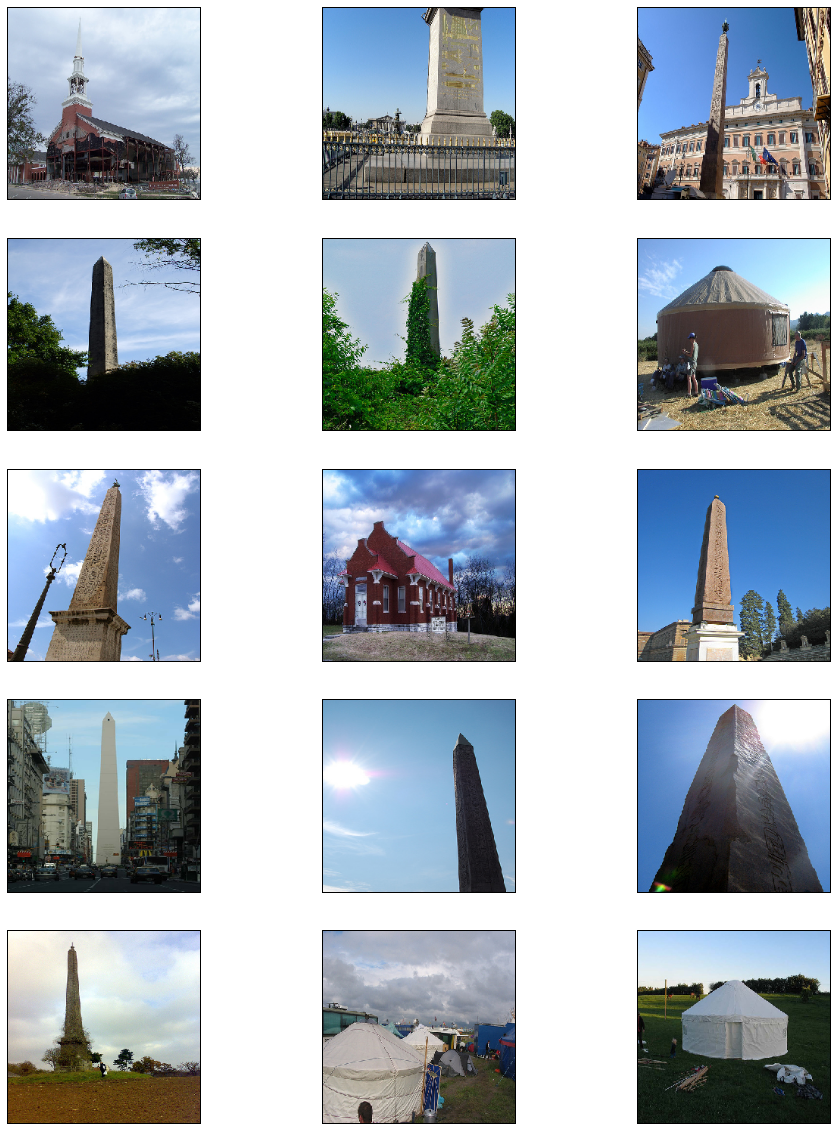

In [6]:
top = 15

fig, axes_matrix = plt.subplots(nrows=top/3, ncols=3, figsize=[16, 20])

for max_idx, axes in zip(max_idxs[:top], axes_matrix.flatten()):
    axes.imshow(img_loader_color.test_data[max_idx].transpose(1, 2, 0))
    
    axes.set_xticks([])
    axes.set_yticks([])

### Display Probability Distributions

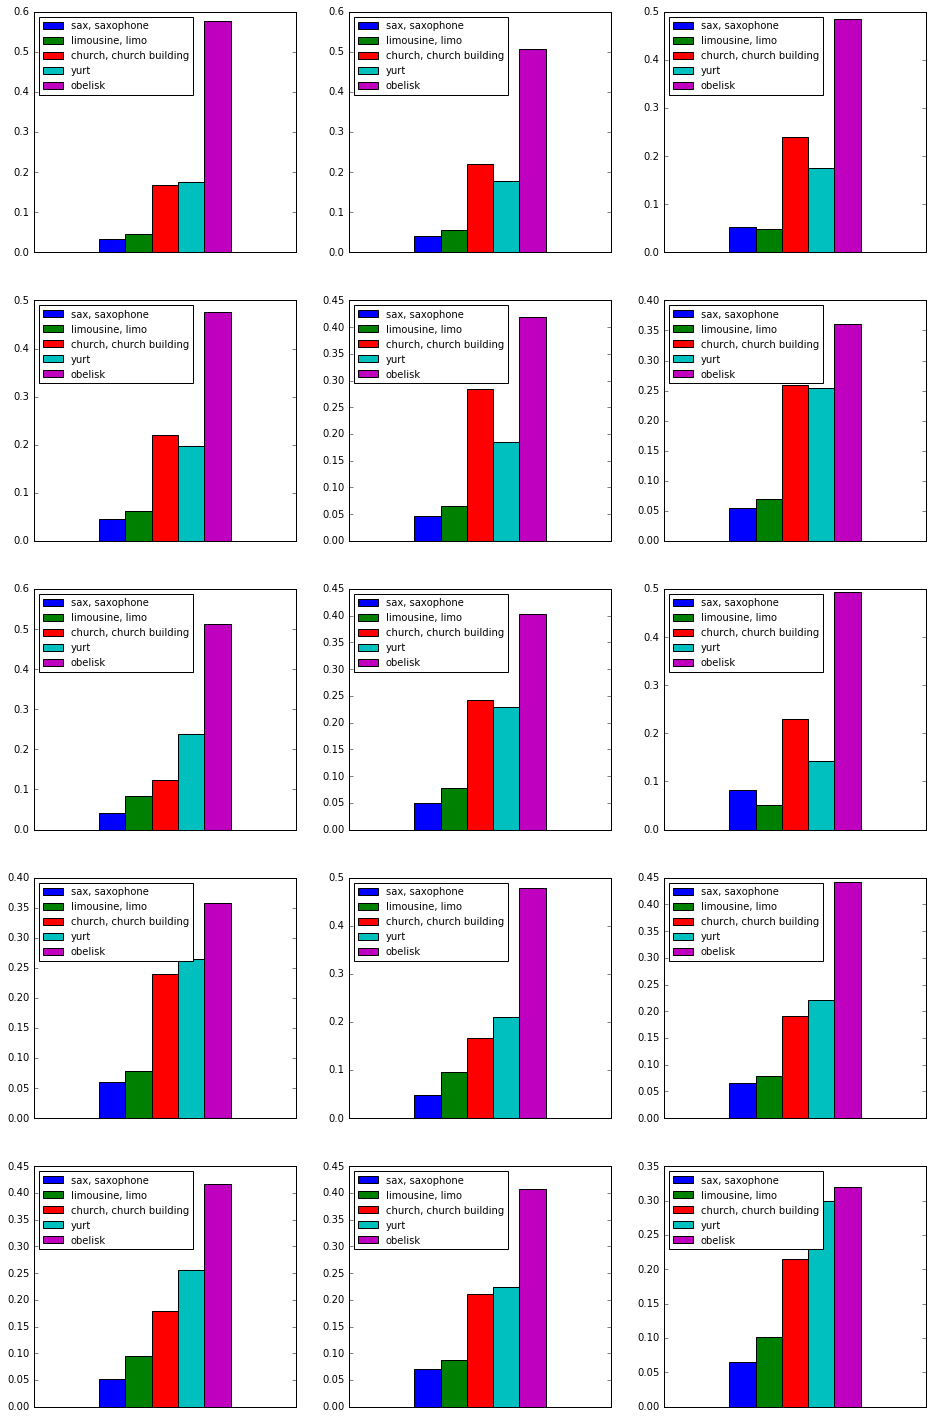

In [19]:
fig, axes_matrix = plt.subplots(nrows=top/3, ncols=3, figsize=[16, 25])

for max_idx, axes in zip(max_idxs[:top], axes_matrix.flatten()):
    df = pd.DataFrame(probs[max_idx]).T
    df.columns = classnames
    
    df.plot(kind='bar', ax=axes)
    axes.set_xticks([])
    axes.legend(loc='upper left', prop={'size':10})

### Plot Softmax Scores in 2D

In [68]:
def plot_reduxed(X):
    fig = plt.figure(figsize=[10, 10])
    
    ids = np.array([[i for _ in range(20)] for i in range(5)]).flatten()
    
    df = pd.DataFrame(X)
    df['id'] = ids

    axes = plt.gca()

    colors = ['y', 'c', 'r', 'g', 'b']

    for i, group in df.groupby('id'):
        axes = group.plot(ax=axes, kind='scatter', x=0, y=1, c=colors[i], s=120, label=classnames[i])

    axes.legend(loc='upper left')
    axes.set_xticks([])
    axes.set_yticks([])
    axes.set_xlabel('')
    axes.set_ylabel('')

### PCA

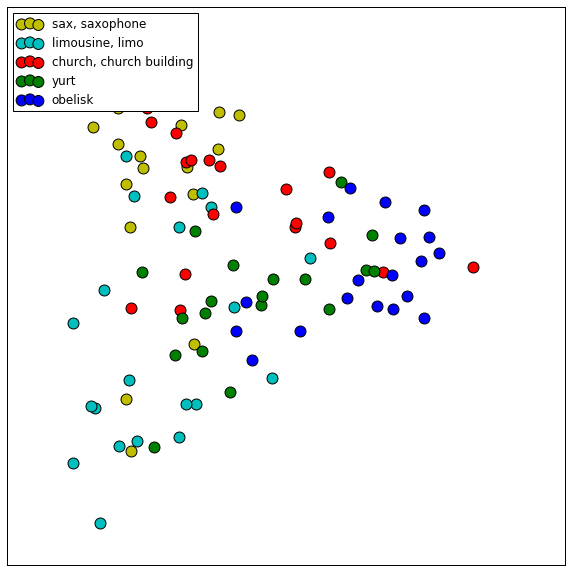

In [72]:
from sklearn import decomposition

pca = decomposition.PCA(n_components=2)
pca.fit(probs)
X = pca.transform(probs)

plot_reduxed(X)

### T-SNE

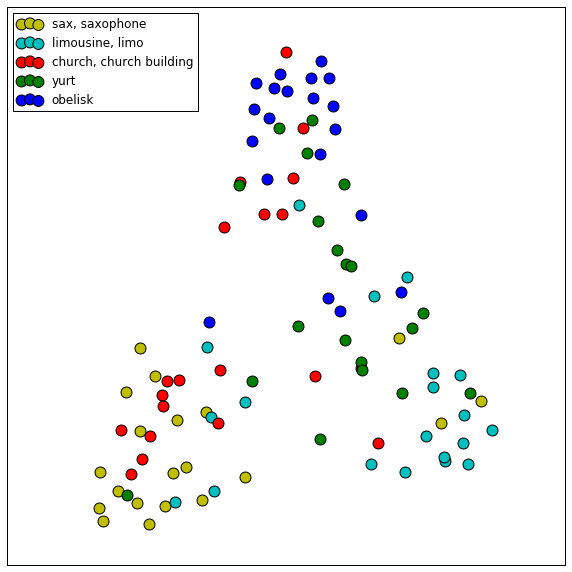

In [71]:
import tsne

tsned = tsne.bh_sne(probs)

plot_reduxed(tsned)